In [1]:
!pip install Sastrawi

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
from collections import Counter
import pickle
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize


pd.set_option('max_columns', 1000)
pd.set_option('max_rows', 1000)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
cols = ['Kode Berita','Judul Berita','Isi Berita', 'Kategori']

# Hoax data
hoax = pd.read_excel('C:/Users/ASUS/Downloads/Data hoax (1)_100.xlsx', usecols=cols)

# Non Hoax Data
nonhoax = pd.read_excel('C:/Users/ASUS/Downloads/Data 4 sumber.xlsx', usecols=cols)

# Concat Data and Shuffle 
df = pd.concat([hoax, nonhoax], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv('C:/Users/ASUS/Downloads/Data 80-20.csv', index_label=None, index=False)

In [4]:
cols = ['Kode Berita','Judul Berita','Isi Berita', 'Kategori']
df = pd.read_csv('C:/Users/ASUS/Downloads/Data 80-20.csv', usecols=cols)

In [5]:
df.head(10)

,Kode Berita,Judul Berita,Isi Berita,Kategori
0,Nhoax_28,Kasus Baru Corona Eropa Berlipat Ganda 10 Hari...,Kasus virus Corona COVID-19 Eropa naik dua kal...,0
1,Nhoax_73,Tanda dan Gejala Kanker Serviks,Kanker serviks adalah jenis kanker yang terjad...,0
2,Nhoax_5,5 Masalah yang Muncul Akibat Tidur Kurang dari...,Berapa jam Anda tertidur setiap malam? Jika ku...,0
3,Hoax_3,Pengecilan Otak Pada Anak-Anak Karena Radiasi...,Bgi yg punya anak putra putrinya harus di awas...,1
4,Hoax_48,MENGETAHUI KANDUNGAN PASTA GIGI DARI KODE WARNA,Coba cek kode warna register pd pasta gigi and...,1
5,Hoax_65,Cara Cepat Cek Jantung Dengan Air dan Es Batu,INGIN MENGETAHUI BAGAIMANA KESEHATAN JANTUNG A...,1
6,Hoax_83,Nasi Padang Menjadi Sumber Penularan Covid-19,Nasi Padang sumber penularan virus Covid-19 . ...,1
7,Nhoax_96,Memahami Penyebab dan Gejala Alergi Penisilin,"Menurut Mayo Clinic, tanda dan gejala alergi p...",0
8,Hoax_7,Dokter Italia Sengaja Membunuh Pasien Virus C...,Seorang dokter Italia di pusat perjuangan nega...,1
9,Hoax_19,"Menkes Mengatakan Masih Ada 3.500 Dokter ""Cada...","Pernyataan Menteri Kesehatan, Terawan Agus Put...",1


# Preprocessing

In [6]:
 def cf_cl_tn(berita):
    # lowercase
    normal_br = str(berita).lower()
    # hapus @username
    normal_br = re.sub(r'@[^\s]+', '', normal_br)
    # hapus hashtag
    normal_br = re.sub(r'#[^\s]+', '', normal_br)
    # hapus tanda baca
    normal_br = re.sub(r'[^\w\s]', '', normal_br) 
    # hapus angka
    normal_br = re.sub(r'\d+', '', normal_br)
    # remove spasi berlebih
    normal_br = re.sub(r'\s+', ' ', normal_br)
    # trim depan belakang
    normal_br = normal_br.strip()
    #tokenizer
    normal_br = ''.join([i for i in normal_br if ord(i) < 5000])
    # regex huruf yang berulang seperti haiiii (untuk fitur unigram)
    normal_regex = re.compile(r"(.)\1{1,}")
    # buang huruf yang berulang
    normal_br = normal_regex.sub(r"\1\1", normal_br)
    return normal_br

In [7]:
df['Isi Berita']=df['Isi Berita'].apply(cf_cl_tn)

In [8]:
def stopword_pp(berita):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    return stopword.remove(berita)

In [9]:
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [10]:
df['Isi Berita']=df['Isi Berita'].apply(stopword_pp)

In [11]:
def stemming_pp(berita):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(berita)

In [12]:
df['Isi Berita']=df['Isi Berita'].apply(stemming_pp)

In [13]:
def stopword_normalisasi_tambahan(berita):
    stopwords = pd.read_csv('C:/Users/ASUS/Downloads/stopword.csv', header=None)

    df_kamus_singkatan = pd.read_csv('C:/Users/ASUS/Downloads/kamus_singkatan - kamus_singkatan (1).csv')
    df_kamus_alay = pd.read_csv('C:/Users/ASUS/Documents/klasifikasi hoax/colloquial-indonesian-lexicon.csv')

    token = nltk.word_tokenize(berita)
    token_new = []
    for k in token:
        if k in df_kamus_singkatan['singkatan'].values:
            k = df_kamus_singkatan.loc[df_kamus_singkatan['singkatan']
                                       == k, 'asli'].values[0]
        if k in df_kamus_alay['slang'].values:
            k = df_kamus_alay.loc[df_kamus_alay['slang']
                                  == k, 'formal'].values[0]
        if k not in stopwords[0].values:
            token_new.append(k)

    str_clean = ' '.join(token_new)
    return str_clean

In [14]:
df['Isi Berita']=df['Isi Berita'].apply(stopword_normalisasi_tambahan)

In [15]:
df['Isi Berita']

0      kasus virus covid covid eropa naik kali lipat ...
1      kanker serviks jenis kanker jadi selsel leher ...
2      berapa jam tidur malam kurang tujuh jam perlu ...
3      punya anak putra putri awasin suka main hpini ...
4      coba cek kode warna register pasta gigi letak ...
5      tahu bagaimana sehat jantung tes sederhana det...
6      nasi padang sumber tular virus covid coba baya...
7      mayo clinic tanda gejala alergi penisilin seri...
8      orang dokter italia pusat juang negara lawan v...
9      nyata menteri sehat awan agus putranto soal ba...
10     pandemi virus covid china tengah hadap jadi lu...
11     paruparu basah rupa istilah rujuk sakit pneumo...
12     usaha obat bas swiss novartis lampu hijau bada...
13     noorsy video kata thermo gun laser resiko otak...
14     anosmia bukan gejala khas virus memang dulu pe...
15     laku imunisasi anak rupa penting meski khawati...
16     paham betul teori generatio spontanea runtuh s...
17     anggur murah giur info w

# Feature Section TF-IDF

In [16]:
max_features = 5000

print ("------- TF-IDF on Isi Berita -------")

tf_idf = TfidfVectorizer(max_features=max_features, binary=True)
tfidf_mat = tf_idf.fit_transform(df['Isi Berita']).toarray()

print("TF-IDF ", type(tfidf_mat), tfidf_mat.shape)

------- TF-IDF on Isi Berita -------
TF-IDF  <class 'numpy.ndarray'> (200, 2542)


In [17]:
terms = tf_idf.get_feature_names()

# Menjumlah nilai tf-idf dr setiap kata - antar dokumen
sums = tfidf_mat.sum(axis=0)

# menghubungkan setiap kata pada perhitungan jumlah tf-idf
data = []
for col, term in enumerate(terms):
    data.append((term, sums[col] ))

ranking = pd.DataFrame(data, columns=['Kata','TF-IDF'])
ranking = ranking.sort_values('TF-IDF', ascending=False)

ranking.head(10)

,Kata,TF-IDF
444,covid,6.325811
1597,orang,5.356825
2484,virus,5.355983
911,jadi,5.283681
2010,sebut,4.811156
2024,sehat,4.634741
1958,sakit,4.532380
1253,lebih,4.116984
193,banyak,4.040200
765,hari,3.756030


# Modelling

In [18]:
label = df['Kategori'].tolist()

In [19]:
X = pd.DataFrame(tfidf_mat)
y = df.Kategori

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Data latih: ',np.shape(X_train))
print('Data Uji: ',np.shape(X_test)) 

Data latih:  (160, 2542)
Data Uji:  (40, 2542)


In [21]:
from sklearn.preprocessing import MinMaxScaler
def num_pipe(impute=None, transform='yeo-johnson', scaling='minmax'):
    if impute is None:
        steps = []
    if transform is not None:
        steps.append(('transformer', PowerTransformer(transform)))
    if scaling == 'minmax':
        steps.append(('scaler', MinMaxScaler()))
    return Pipeline(steps)

In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax', transform='yeo-johnson'), X.columns)
])

In [23]:
from sklearn.model_selection import StratifiedKFold
cv_method = StratifiedKFold(n_splits=10, random_state=999)

In [24]:
params_mnb = {'mnb__alpha': np.logspace(0,-9, num=10), 'mnb__fit_prior' : [True, False]}
params_nb = {'nb__var_smoothing' : np.logspace(0,-9, num=10)}

# Naive Bayes

In [25]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('nb', GaussianNB())
])

model_nb = GridSearchCV(pipeline, params_nb, cv=cv_method, n_jobs=-1, verbose=1)
model_nb.fit(X_train, y_train)

print(model_nb.best_params_)
print(model_nb.score(X_train, y_train), model_nb.best_score_, model_nb.score(X_test, y_test))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.0min finished


{'nb__var_smoothing': 1.0}
1.0 0.85625 0.825


In [26]:
pd.DataFrame(model_nb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,26.041994,1.104018,0.531691,0.091662,1.0,{'nb__var_smoothing': 1.0},0.8125,0.8125,0.8750,1.0000,0.8750,0.6875,0.8125,0.8750,0.8750,0.9375,0.85625,0.079304,1
1,25.880241,1.930201,0.545855,0.081647,0.1,{'nb__var_smoothing': 0.1},0.8125,0.7500,0.6875,0.8125,0.6875,0.8750,0.6250,0.6875,0.8125,0.7500,0.75000,0.073951,2
2,26.316367,3.196692,0.554719,0.095703,0.01,{'nb__var_smoothing': 0.01},0.8125,0.7500,0.7500,0.8125,0.6875,0.7500,0.6250,0.6250,0.8125,0.6875,0.73125,0.068750,3
3,25.999896,2.011534,0.542151,0.086011,0.001,{'nb__var_smoothing': 0.001},0.8125,0.6875,0.6875,0.8125,0.7500,0.6875,0.6250,0.6250,0.7500,0.6875,0.71250,0.063738,6
4,25.673555,2.806531,0.514621,0.062081,0.0001,{'nb__var_smoothing': 0.0001},0.8125,0.6875,0.6875,0.8125,0.7500,0.6875,0.6250,0.6250,0.7500,0.6875,0.71250,0.063738,6
5,26.237564,2.271084,0.483054,0.067915,0.00001,{'nb__var_smoothing': 1e-05},0.8125,0.6875,0.6875,0.8125,0.7500,0.6875,0.6250,0.6250,0.7500,0.6875,0.71250,0.063738,6
6,26.371504,2.703069,0.547611,0.091958,0.000001,{'nb__var_smoothing': 1e-06},0.8125,0.7500,0.6875,0.8125,0.7500,0.6875,0.6250,0.6250,0.7500,0.6875,0.71875,0.064043,4
7,26.106466,2.783630,0.549474,0.082592,0.0,{'nb__var_smoothing': 1e-07},0.8125,0.7500,0.6875,0.8125,0.7500,0.6875,0.6250,0.6250,0.7500,0.6875,0.71875,0.064043,4
8,26.540851,2.606046,0.546757,0.077959,0.0,{'nb__var_smoothing': 1e-08},0.8125,0.6875,0.6875,0.8125,0.7500,0.6875,0.6250,0.6250,0.7500,0.6875,0.71250,0.063738,6
9,25.127939,0.922511,0.481404,0.083250,0.0,{'nb__var_smoothing': 1e-09},0.8125,0.6875,0.6875,0.8125,0.7500,0.6875,0.6250,0.6250,0.7500,0.6875,0.71250,0.063738,6


In [27]:
model_nb.score(X_test, y_test)

0.825

In [28]:
print("Train report")
print(classification_report(y_train, model_nb.predict(X_train)))

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



In [29]:
print("Test report")
print(classification_report(y_test, model_nb.predict(X_test)))

Test report
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        20
           1       0.78      0.90      0.84        20

    accuracy                           0.82        40
   macro avg       0.83      0.82      0.82        40
weighted avg       0.83      0.82      0.82        40



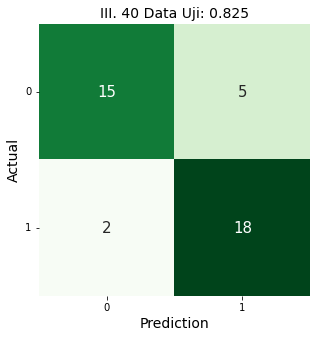

In [44]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(9, 5))
labels = np.unique(y_test)
cm = confusion_matrix(y_test, model_nb.predict(X_test), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'III. 40 Data Uji: {model_nb.score(X_test, y_test):.3f}', fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center');

In [32]:
pred_prob_nb = model_nb.predict_proba(X)
pred_nb = model_nb.predict(X)
nb_df = pd.DataFrame(data=pred_prob_nb,index=X.index,columns=['Hoax','NHoax'])
nb_df['Kategori'] = pred_nb
nb_df['Kategori'] = np.where(nb_df['Kategori'], 'Hoax', 'NHoax')
nb_df['Kode Berita'] = df['Kode Berita']
nb_df

,Hoax,NHoax,Kategori,Kode Berita
0,9.978787e-01,2.121258e-03,NHoax,Nhoax_28
1,9.921095e-01,7.890465e-03,NHoax,Nhoax_73
2,7.988919e-01,2.011081e-01,NHoax,Nhoax_5
3,4.895717e-07,9.999995e-01,Hoax,Hoax_3
4,2.714214e-04,9.997286e-01,Hoax,Hoax_48
5,6.475659e-05,9.999352e-01,Hoax,Hoax_65
6,4.214968e-05,9.999579e-01,Hoax,Hoax_83
7,9.973559e-01,2.644119e-03,NHoax,Nhoax_96
8,1.900491e-02,9.809951e-01,Hoax,Hoax_7
9,7.232950e-03,9.927671e-01,Hoax,Hoax_19


# Multinomial Naive Bayes

In [33]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('mnb', MultinomialNB())
])

model_mnb = GridSearchCV(pipeline, params_mnb, cv=cv_method, n_jobs=-1, verbose=1)
model_mnb.fit(X_train, y_train)

print(model_mnb.best_params_)
print(model_mnb.score(X_train, y_train), model_mnb.best_score_, model_mnb.score(X_test, y_test))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 20.1min finished


{'mnb__alpha': 0.1, 'mnb__fit_prior': True}
1.0 0.80625 0.875


In [34]:
pd.DataFrame(model_mnb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__alpha,param_mnb__fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,47.381975,12.833103,1.303029,0.516991,1.0,True,"{'mnb__alpha': 1.0, 'mnb__fit_prior': True}",0.8125,0.8125,0.6875,0.8750,0.8750,0.8125,0.6250,0.7500,0.8125,0.8125,0.78750,0.075000,5
1,61.773336,22.553760,1.259237,0.485443,1.0,False,"{'mnb__alpha': 1.0, 'mnb__fit_prior': False}",0.8125,0.8125,0.6875,0.8750,0.8750,0.8125,0.6250,0.7500,0.8125,0.8125,0.78750,0.075000,5
2,41.550524,15.368124,0.732545,0.424930,0.1,True,"{'mnb__alpha': 0.1, 'mnb__fit_prior': True}",0.8125,0.8125,0.8750,0.8750,0.8125,0.8750,0.6875,0.6875,0.8125,0.8125,0.80625,0.065252,1
3,49.689642,16.219845,0.831706,0.356658,0.1,False,"{'mnb__alpha': 0.1, 'mnb__fit_prior': False}",0.8125,0.8125,0.8750,0.8750,0.8125,0.8750,0.6875,0.6875,0.8125,0.8125,0.80625,0.065252,1
4,31.711308,5.437458,0.616396,0.214253,0.01,True,"{'mnb__alpha': 0.01, 'mnb__fit_prior': True}",0.8125,0.7500,0.8125,0.8750,0.8125,0.9375,0.6250,0.6875,0.8125,0.8125,0.79375,0.084085,3
5,31.643942,7.122338,0.684576,0.345215,0.01,False,"{'mnb__alpha': 0.01, 'mnb__fit_prior': False}",0.8125,0.7500,0.8125,0.8750,0.8125,0.9375,0.6250,0.6875,0.8125,0.8125,0.79375,0.084085,3
6,41.160048,16.624532,0.623824,0.320048,0.001,True,"{'mnb__alpha': 0.001, 'mnb__fit_prior': True}",0.8125,0.7500,0.8125,0.8125,0.7500,0.9375,0.6250,0.6875,0.8125,0.6875,0.76875,0.084085,7
7,41.551144,14.605904,0.822038,0.389175,0.001,False,"{'mnb__alpha': 0.001, 'mnb__fit_prior': False}",0.8125,0.7500,0.8125,0.8125,0.7500,0.9375,0.6250,0.6875,0.8125,0.6875,0.76875,0.084085,7
8,56.303744,17.468247,1.049460,0.561424,0.0001,True,"{'mnb__alpha': 0.0001, 'mnb__fit_prior': True}",0.8125,0.7500,0.8125,0.8125,0.7500,0.9375,0.6250,0.6875,0.8125,0.6875,0.76875,0.084085,7
9,48.291426,11.979208,0.647449,0.312840,0.0001,False,"{'mnb__alpha': 0.0001, 'mnb__fit_prior': False}",0.8125,0.7500,0.8125,0.8125,0.7500,0.9375,0.6250,0.6875,0.8125,0.6875,0.76875,0.084085,7


In [35]:
model_mnb.score(X_test, y_test)

0.875

In [36]:
print("Train report")
print(classification_report(y_train, model_mnb.predict(X_train)))
print()
print("Test report")
print(classification_report(y_test, model_mnb.predict(X_test)))

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160


Test report
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        20
           1       1.00      0.75      0.86        20

    accuracy                           0.88        40
   macro avg       0.90      0.88      0.87        40
weighted avg       0.90      0.88      0.87        40



In [37]:
pred_prob_mnb = model_mnb.predict_proba(X)
pred_mnb = model_mnb.predict(X)
mnb_df = pd.DataFrame(data=pred_prob_mnb,index=X.index,columns=['Hoax','NHoax'])
mnb_df['Kategori'] = pred_mnb
mnb_df['Kategori'] = np.where(mnb_df['Kategori'], 'Hoax', 'NHoax')
mnb_df['Kode Berita'] = df['Kode Berita']
mnb_df

,Hoax,NHoax,Kategori,Kode Berita
0,1.000000e+00,9.282233e-16,NHoax,Nhoax_28
1,9.998959e-01,1.040839e-04,NHoax,Nhoax_73
2,9.995868e-01,4.132447e-04,NHoax,Nhoax_5
3,1.210279e-27,1.000000e+00,Hoax,Hoax_3
4,1.745966e-14,1.000000e+00,Hoax,Hoax_48
5,4.960876e-26,1.000000e+00,Hoax,Hoax_65
6,2.230528e-22,1.000000e+00,Hoax,Hoax_83
7,1.000000e+00,7.808381e-19,NHoax,Nhoax_96
8,5.440804e-02,9.455920e-01,Hoax,Hoax_7
9,7.953337e-20,1.000000e+00,Hoax,Hoax_19


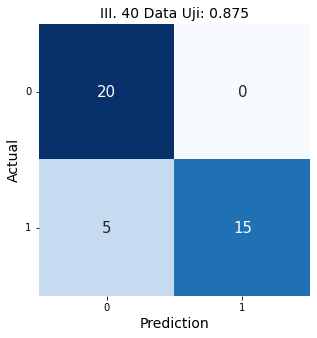

In [46]:
plt.figure(figsize=(8, 5))
labels = np.unique(y_test)
cm = confusion_matrix(y_test, model_mnb.predict(X_test), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'III. 40 Data Uji: {model_mnb.score(X_test, y_test):.3f}',fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center');

# Data Uji

In [39]:
df_test = pd.read_csv('C:/Users/ASUS/Downloads/Data 80-20.csv', usecols=cols)

In [40]:
X_p2 = X.iloc[199:] # mengambil atribut/fitur data
y_p2 = y[199:]
teks_p2 = df_test.iloc[199:,2].values[0]

In [42]:
new_pred_nb = model_nb.predict(X_p2)
new_pred_mnb = model_mnb.predict(X_p2)

In [43]:
from sklearn.metrics import accuracy_score
print('Berita asli:')
print(teks_p2)

print(100*'=', '\n')

if new_pred_nb == 1:
    print('Hasil Prediksi Naive Bayes = HOAX\n')
else:
    print('Hasil Prediksi Naive Bayes = NONHOAX')
print(accuracy_score(y_p2, new_pred_nb))

print(100*'=', '\n')

if new_pred_mnb == 1:
    print('Hasil Prediksi Multinomial Naive Bayes = HOAX')
else:
    print('Hasil Prediksi Multinomial Naive Bayes = NONHOAX')
print(accuracy_score(y_p2, new_pred_mnb))

Berita asli:
Seorang ibu rumah tangga bernama Nunki Herwanti di Semarang, kaget karena dinyatakan positif virus Corona. Wanita yang sedang hamil 5 bulan ini tak menyangka karena selama ini ia tidak pernah bepergian jauh baik dalam kota maupun luar negeri.
Bahkan, ia juga tak pernah kontak fisik dengan orang-orang yang rawan membawa virus Corona. Lantas darimana dia bisa tertular?
Kepada Gubernur Jawa Tengah, Ganjar Pranowo lewat teleconference, Nungki pun menceritakannya kisahnya. 
"Tidak ada riwayat perjalanan ke luar kota, saya juga tidak ada riwayat perjalanan ke luar negeri. Bahkan berkerumunan, maksudnya acara yang sangat besar yang berkerumun juga tidak," kata Nungki kepada Ganjar beberapa waktu lalu, dikutip dari 20detik.
Dia menambahkan bahwa kegiatan sehari-harinya sebelum timbul gejala adalah antar-jemput anak. Serta tidak melakukan kontak fisik dengan siapapun. Namun kegiatan lain yang dia lakukan adalah berkontak dengan tukang sayur keliling langganannya. 


Hasil Prediksi 